In [1]:
"""
NetworkX + Anomaly Detection
"""
import networkx as nx
from sklearn.ensemble import IsolationForest

In [2]:
# Sample data
users = [
{"id": 0, "name": "Hero"},
{"id": 1, "name": "Dunn"},
{"id": 2, "name": "Sue"},
{"id": 3, "name": "Chi"},
{"id": 4, "name": "Thor"},
{"id": 5, "name": "Clive"},
{"id": 6, "name": "Hicks"},
{"id": 7, "name": "Devin"},
{"id": 8, "name": "Kate"},
{"id": 9, "name": "Klein"}
]

friendship_pairs = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4),
(4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)]

In [3]:
DG = nx.DiGraph()   # Directed graph

# add nodes
for user in users:
    DG.add_node(user["id"], name=user["name"])

# add edges
for pair in friendship_pairs:
    DG.add_edge(pair[0], pair[1])

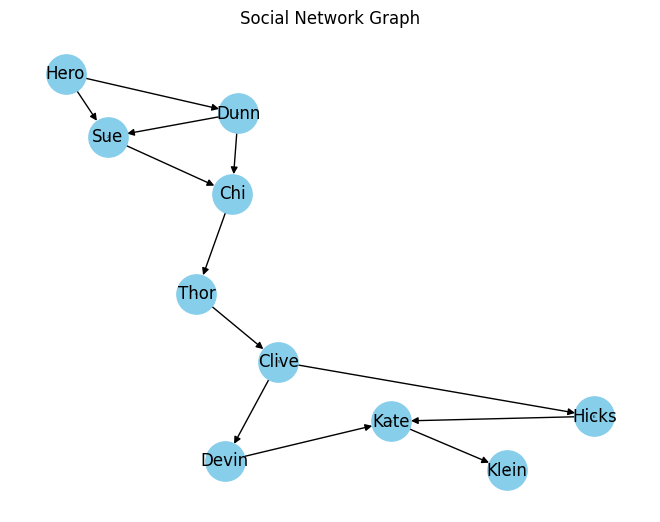

In [4]:
import matplotlib.pyplot as plt

# draw the graph
pos = nx.spring_layout(DG, seed=42)  # layout algorithm
nx.draw(DG, pos, with_labels=True, node_color="skyblue", node_size=800, font_size=3)

# add labels
labels = {user["id"]: user["name"] for user in users}
# labels = {user["id"]: user["id"] for user in users}  # -- to show user id value instead name.
nx.draw_networkx_labels(DG, pos, labels)

plt.title("Social Network Graph")
plt.show()

In [5]:
# convert to features ( eg: degree, betweenness )
features = []
for node in DG.nodes():
    features.append([
        DG.degree(node),         # number of connections
        # print(users[node]["name"]),
        # print("node:", node, "name:",labels[node], "\tDG.degree(node):", DG.degree(node)),
        nx.betweenness_centrality(DG)[node],  # Influence in the network
        # print("node:", node, "nx.betweenness_centrality(DG)[node]:", nx.betweenness_centrality(DG)[node])
    ])
#Train anomaly detectin model
model = IsolationForest(contamination=0.3)            # 0.1, 0.2,  0.3   ---must be between [0 - 0.5]  - TRY 
model.fit(features)
anomalies = model.predict(features)
print("anomalies:",anomalies)

# Flag suspicious users
suspicious_users = [users[i]["name"] for i, anomaly in enumerate(anomalies) if anomaly == -1 ]
print("\nPotential fraudsters: ", suspicious_users)

anomalies: [ 1  1  1 -1 -1  1  1  1  1 -1]

Potential fraudsters:  ['Chi', 'Thor', 'Klein']


In [6]:
print(anomalies)

[ 1  1  1 -1 -1  1  1  1  1 -1]


In [7]:
# pip uninstall kafka
# pip install kafka-python

In [57]:
import kafka
print("Kafka Python Version:", kafka.__version__)

Kafka Python Version: 2.1.5


In [64]:
"""
Real-Time Recommendations with Kafka + Neo4j
Goal: Stream user activity and update recommendations in real time.

Architecture
- Kafka Producer: Sends events like User X liked Post Y.
- Neo4j Streams: Processes events and updates recommendations.
"""
from kafka import KafkaProducer
# from kafka.producer import KafkaProducer
import json

In [66]:
# ----- Step 1: Simulate Kafka Events ------       DID NOT WORK --------
# producer = KafkaProducer(bootstrap_servers='localhost:9092', value_serializer=lambda v: json.dumps(v).encode('utf-8'))
producer = KafkaProducer(bootstrap_servers='127.0.0.1:9092', value_serializer=lambda v: json.dumps(v).encode('utf-8'), request_timeout_ms=30000  # 30-second timeout
                        )

# send a "like" event
event = {"user_id": 0, "action": "LIKES", "target": "music"}

producer.send('user_events', event)
# producer.send(topic='jay2025', value={'user_events': event})
producer.flush()
        

NoBrokersAvailable: NoBrokersAvailable

In [67]:
from kafka import KafkaProducer
import json

In [68]:
# Option 1: Try with a list of brokers         --- DID NOT WORK ---
producer = KafkaProducer(
    bootstrap_servers=['localhost:9092'],  # As a list      -- # List of brokers
    value_serializer=lambda v: json.dumps(v).encode('utf-8')
)

In [37]:
# Option 2: Add timeout (ms)          --- DID NOT WORK ---
producer = KafkaProducer(
    bootstrap_servers='localhost:9092',
    value_serializer=lambda v: json.dumps(v).encode('utf-8'),
    request_timeout_ms=30000  # 30-second timeout
)

In [70]:
# Test connection       ---- DID NOT WORK  --------------
try:
    # producer.send('test_topic', {'key': 'value'})
    producer.send('jay2025', {'key': 'value'})    
    
    # send a "like" event
    # event = {"user_id": 0, "action": "LIKES", "target": "music"}
    # producer.send('user_events', event)
    producer.flush(timeout=10)
    print("Connection successful!")
except Exception as e:
    print(f"Failed: {e}")


# Failed: KafkaTimeoutError: Failed to update metadata after 60.0 secs.

Failed: KafkaTimeoutError: Failed to update metadata after 60.0 secs.


In [40]:
from kafka import KafkaProducer
import json

producer = KafkaProducer(
    bootstrap_servers=['127.0.0.1:9092'],        # # List of brokers
    value_serializer=lambda v: json.dumps(v).encode('utf-8'),
    api_version=(3, 0, 0),
    request_timeout_ms=10000
)

# Test message
try:
    producer.send('user_events', {'user_id': 0, 'action': 'TEST'}).get(timeout=10)
    print("Successfully connected to Kafka!")
except Exception as e:
    print(f"Failed to send message: {e}")

Failed to send message: KafkaTimeoutError: Failed to update metadata after 60.0 secs.


In [43]:
# ----  Test with Minimal Code    ----------
from kafka import KafkaAdminClient

try:
    admin = KafkaAdminClient(bootstrap_servers='127.0.0.1:9092')
    print("Connected! Topics:", admin.list_topics())
except Exception as e:
    print("Connection failed:", e)


Connection failed: NoBrokersAvailable


In [44]:
from kafka import KafkaProducer
import json

producer = KafkaProducer(
    bootstrap_servers=['127.0.0.1:9092'],  # Use IP, NOT 'localhost'
    value_serializer=lambda v: json.dumps(v).encode('utf-8'),
    
    # CRITICAL ADDITIONS:
    api_version=(3, 0, 0),           # Match your Kafka server version
    security_protocol='PLAINTEXT',    # Explicitly declare (even if default)
    request_timeout_ms=30000,         # 30-second timeout
    max_block_ms=60000,               # Max wait for metadata
    retries=5                         # Retry if broker is slow
)

In [55]:
# ----------  Verifying the Topic Exists    ------------
from kafka.admin import KafkaAdminClient

admin = KafkaAdminClient(bootstrap_servers='127.0.0.1:9092')
if 'jay2025' in admin.list_topics():
    print("Topic 'jay2025' exists!")
else:
    print("Topic missing. Create it with:")
    print("kafka-topics.sh --create --topic jay2025 --bootstrap-server localhost:9092")

NoBrokersAvailable: NoBrokersAvailable

In [46]:
# ----------- Test with This Exact Script    ----------
from kafka import KafkaAdminClient

def test_connection():
    try:
        admin = KafkaAdminClient(
            bootstrap_servers='127.0.0.1:9092',
            api_version=(3, 0, 0),
            security_protocol='PLAINTEXT',
            request_timeout_ms=30000         # 30-second timeout
        )
        print("SUCCESS! Topics:", admin.list_topics())
        return True
    except Exception as e:
        print("FAILED:", e)
        return False

if test_connection():
    producer = KafkaProducer(
        bootstrap_servers=['127.0.0.1:9092'],
        value_serializer=lambda v: json.dumps(v).encode('utf-8'),
        api_version=(3, 0, 0),
        security_protocol='PLAINTEXT',    # Explicitly declare (even if default)
        request_timeout_ms=30000,         # 30-second timeout
        max_block_ms=60000,               # Max wait for metadata
        retries=5                         # Retry if broker is slow
    )
    # producer.send('test_topic', {'key': 'value'}).get(timeout=10)
    producer.send('jay2025', {'key': 'value'}).get(timeout=10)
    print("Message sent successfully!")
    producer.flush()

KeyboardInterrupt: 

In [49]:
# --------  Test with kafka-python Directly  --------
from kafka import KafkaAdminClient

try:
    admin = KafkaAdminClient(bootstrap_servers='localhost:9092')
    print(admin.list_topics())  # Should print existing topics
except Exception as e:
    print(f"Connection failed: {e}")

Connection failed: NodeNotReadyError: 0


In [50]:
from kafka import KafkaProducer
import json

producer = KafkaProducer(
    bootstrap_servers=['127.0.0.1:9092'],  # ← Critical fix
    value_serializer=lambda v: json.dumps(v).encode('utf-8'),
    api_version=(2, 8, 1),
    request_timeout_ms=10000
)

# Test message
try:
    producer.send('test', {'key': 'value'}).get(timeout=10)
    print("Message sent successfully!")
except Exception as e:
    print("Failed:", e)
finally:
    producer.flush()

Failed: KafkaTimeoutError: Failed to update metadata after 60.0 secs.


In [52]:
#------------     Sending Messages to "jay2025" (Producer)       ----------------
from kafka import KafkaProducer
import json

producer = KafkaProducer(
    bootstrap_servers=['127.0.0.1:9092'],
    value_serializer=lambda v: json.dumps(v).encode('utf-8')
)

# Send a message to "jay2025"
producer.send(
    topic='jay2025',  # ← Specify your topic name here
    value={'user_id': 1, 'action': 'purchase'}
)

# Ensure delivery
producer.flush()

NoBrokersAvailable: NoBrokersAvailable

In [53]:
# ----------    Reading Messages from "jay2025" (Consumer)  --------

from kafka import KafkaConsumer

consumer = KafkaConsumer(
    'jay2025',  # ← Your topic name
    bootstrap_servers=['127.0.0.1:9092'],
    auto_offset_reset='earliest',  # Start from first message
    value_deserializer=lambda x: json.loads(x.decode('utf-8'))
)

for message in consumer:
    print(f"Received: {message.value}")

NoBrokersAvailable: NoBrokersAvailable

In [59]:
# --------     Full Example with Error Handling        -------------
from kafka import KafkaProducer, KafkaConsumer
from kafka.errors import KafkaError

# Producer with error handling
try:
    producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'])
    future = producer.send('jay2025', b'Test message')
    future.get(timeout=10)  # Wait for confirmation
    print("Message sent to 'jay2025'")
except KafkaError as e:
    print(f"Failed to send: {e}")
finally:
    producer.close()

# Consumer
try:
    consumer = KafkaConsumer('jay2025', bootstrap_servers=['127.0.0.1:9092'])
    for msg in consumer:
        print(f"Received from 'jay2025': {msg.value.decode()}")
except KeyboardInterrupt:
    consumer.close()

Failed to send: NoBrokersAvailable


NoBrokersAvailable: NoBrokersAvailable

In [ ]:
"""
Export your graph to a GEXF file:
"""
nx.write_gexf(G, "social_network.gexf")